In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import dit_fast_attention
import os
file_path=os.path.abspath(dit_fast_attention.__file__)
dir_path=os.path.dirname(file_path)
os.chdir(dir_path)
from diffusers import DiTPipeline, DPMSolverMultistepScheduler
import argparse
import torch
from evaluation import test_latencies
from dit_fast_attention import transform_model_fast_attention
import numpy as np
import os
import time
import thop
from utils import calculate_flops
import re
import seaborn as sns
# sns.set_style("whitegrid")

from collections import namedtuple
os.environ["https_proxy"]="http://10.10.20.100:1089"


/home/yuanzhihang/anaconda3/envs/dit_fa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yuanzhihang/anaconda3/envs/dit_fa/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yuanzhihang/anaconda3/envs/dit_fa/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/yuanzhihang/anaconda3/envs/dit_fa/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Plea

In [10]:
from torch import tensor
def parse_txt_data(txt_data):
    data = []
    for block in txt_data.split('\n\n'):
        lines = block.strip().split('\n')
        for line in lines:
            if line.startswith('Namespace'):
                namespace = re.findall(r"Namespace\((.*)\)", line)[0]
                namespace_args = [arg.split('=') for arg in namespace.split(', ')]
                namespace_dict = {arg[0]: eval(arg[1]) for arg in namespace_args}
                # namespace_obj = namedtuple('Namespace', namespace_dict.keys())(**namespace_dict)
                data.append(namespace_dict)
            # elif line.startswith('calib_ssim'):
            #     calib_ssim = float(line.split('=')[1])
            #     # data.append(calib_ssim)
            #     namespace_dict["calib_ssim"] = calib_ssim
            elif line.startswith('{'):
                metrics = eval(line)
                # data.append(metrics)
                namespace_dict["metrics"] = metrics
            elif line.startswith('macs'):
                macs = eval(line.split('=')[1])
                namespace_dict["macs"] = macs
                # data.append(macs)
            elif line.startswith('attn_mac'):
                attn_mac = float(line.split('=')[1])
                # data.append(attn_mac)
                namespace_dict["attn_mac"] = attn_mac
            elif line.startswith('latencies'):
                latencies = eval(line.split('=')[1])
                # data.append(latencies)
                namespace_dict["latencies"] = latencies
                # print(latencies)
    return data

txt_data=open("output/results.txt").read()
data=parse_txt_data(txt_data)


[210.0112, 209.7769012451172, 209.1457977294922, 206.2904052734375, 202.5522003173828, 187.7061004638672, 174.7324981689453]
[2.705, 2.402631548928, 2.073462571008, 1.819791065088, 1.589674770432, 1.374657970176, 1.197691895808]
[210.0112, 206.74850463867188, 199.94979858398438, 139.3878936767578, 112.57160186767578, 65.49549865722656, 56.93790054321289]
[2.705, 2.6526791761919997, 2.505308110848, 2.285459472384, 2.0704426721280003, 1.8723373056000001, 1.741877673984]
[210.0112, 207.73109436035156, 205.71640014648438, 204.2415008544922, 202.59100341796875, 202.4241943359375, 201.72120666503906]
[2.705, 2.405047468032, 2.087354105856, 1.857841790976, 1.67302397952, 1.52806883328, 1.427808190464]
[210.0112, 209.20919799804688, 209.50469970703125, 208.9467010498047, 207.7812042236328, 206.37680053710938]
[2.705, 2.5560424120319998, 2.473901162496, 2.353105207296, 2.280627634176, 2.183990870016]


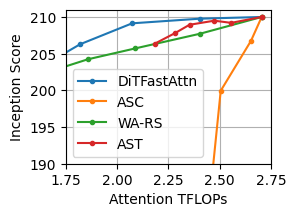

In [11]:
# Ablation plot
seqs=[1,0.975,0.95,0.925,0.9,0.875,0.85]
seqs=[0.975,0.95,0.925,0.9,0.875,0.85]
# sfig, saxes = plt.subplots(1,3,figsize=(3.8*3,1.5))
fig=plt.figure(figsize=(9,2))
ax=fig.add_subplot(131)
# titles=["512x512 DiT-XL","1024x1024 PixArt-Sigma-XL","2048x2048 PixArt-Sigma-XL"]

raw_macs=2705/1e3
raw_fid=30.868
raw_is=210.0112
for modeli, model_name in enumerate(["facebook/DiT-XL-2-512"]):
    nbatch=8 if model_name=="facebook/DiT-XL-2-512" else 1
    
    for ablation in ["","full_attn+cfg_attn_share","residual_window_attn","output_share"]:
        # lats_all=[]
        # lats_attn=[]
        if ablation=="output_share":
            seqs=seqs[1:]
        iss=[raw_is]
        attn_macs=[raw_macs]
        visited=[]
        for threshold in seqs:
            for l in data[::-1]:
                # print(l)
                if l["model"]==model_name and l["n_calib"]==8 and l["n_steps"]==20 and \
                    l["eval_n_images"]==5000 and "attn_mac" in l and l["threshold"]==threshold \
                        and l.get("ablation","")==ablation and l["window_size"]==128:
                    # if "metrics" not in l or not "IS" in l["metrics"]:
                    #     continue
                    if "metrics" not in l or not "IS" in l["metrics"]:
                        continue
                    if l["threshold"] in visited:
                        continue
                    visited.append(l["threshold"])
                    attn_macs.append(l["attn_mac"]/1e3)
                    iss.append(l["metrics"]["IS"][0].item())
                    # lats_all.append(l["latencies"][f"{nbatch}_all"])
                    # lats_attn.append(l["latencies"][f"{nbatch}_attn"])
        ablation="DiTFastAttn" if ablation=="" else ablation
        ablation=ablation.replace("full_attn+","").replace("cfg_attn_share","ASC").replace("residual_window_attn","WA-RS").replace("output_share","AST").replace("+without_residual"," w/o")
        ax.plot(attn_macs, iss,".-", label=f"{ablation}")
        # ax.plot(attn_macs, lats_attn, label="Attention")
        # ax.set_title(titles[modeli])
        ax.legend()
        ax.set_ylabel("Inception Score")
        ax.set_xlabel("Attention TFLOPs")
        # print(f"{model_name} IS",iss)
        # print(f"{model_name} Attention",attn_macs)
        print(iss)
        print(attn_macs)

plt.ylim(190,211)
plt.xlim(1.75,2.75)
# sfig.show()
# fig.savefig("plot/ablation.pdf", bbox_inches='tight')
ax.grid()
    

In [4]:
pipe = DiTPipeline.from_pretrained("facebook/DiT-XL-2-512", torch_dtype=torch.float16).to("cuda")
calib_x=torch.randint(0, 1000, (1,),generator=torch.Generator().manual_seed(3)).to("cuda")
n_stepss=[20,30,40,50]

steps_macs=[]
for n_steps in n_stepss:
    _,a_macs=calculate_flops(pipe,calib_x,n_steps=n_steps)
    steps_macs.append(a_macs/1e3)

/home/yuanzhihang/anaconda3/envs/dit_fa/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
/home/yuanzhihang/anaconda3/envs/dit_fa/lib/python3.10/site-packages/diffusers/pipelines/dit/pipeline_dit.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_labels = torch.tensor(class_labels, device=self._execution_device).reshape(-1)
 15%|█▌        | 3/20 [00:00<00:03,  5.16it/s]

Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size([2, 1024, 1152])
Attention input shape is torch.Size([2, 1024, 1152]), encoder_hidden_states shape is torch.Size(

100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


macs is 20988.72778752 G, attn is 2705.82939648 G, attn2_ops is 0.0 G


100%|██████████| 30/30 [00:01<00:00, 18.79it/s]


macs is 31483.09168128 G, attn is 4058.74409472 G, attn2_ops is 0.0 G


100%|██████████| 40/40 [00:02<00:00, 19.03it/s]


macs is 41977.45557504 G, attn is 5411.65879296 G, attn2_ops is 0.0 G


100%|██████████| 50/50 [00:02<00:00, 18.97it/s]

macs is 52471.8194688 G, attn is 6764.5734912 G, attn2_ops is 0.0 G


In [12]:
# Ablation plot
seqs=[1,0.975,0.95,0.925,0.9,0.875,0.85]
seqs=[0.975,0.95,0.925,0.9,0.875,0.85]
# sfig, saxes = plt.subplots(1,3,figsize=(3.8*3,1.5))
# n_stepss=[20,30,40]
n_stepss=[20,30,40,50]
ax=fig.add_subplot(132)
# titles=["512x512 DiT-XL","1024x1024 PixArt-Sigma-XL","2048x2048 PixArt-Sigma-XL"]

for modeli, model_name in enumerate(["facebook/DiT-XL-2-512"]):
    nbatch=8 if model_name=="facebook/DiT-XL-2-512" else 1
    for n_steps in n_stepss:
        iss=[]
        attn_macs=[]
        visited=[]
        for threshold in seqs:
            for l in data[::-1]:
                # print(l)
                if l["model"]==model_name and l["n_calib"]==8 and l["n_steps"]==n_steps and \
                    l["eval_n_images"]==5000 and "attn_mac" in l and l["threshold"]==threshold and l.get("ablation","")=="":
                    # if "metrics" not in l or not "IS" in l["metrics"]:
                    #     continue
                    if "metrics" not in l or not "IS" in l["metrics"]:
                        continue
                    if l["threshold"] in visited:
                        continue
                    visited.append(l["threshold"])
                    attn_macs.append(l["attn_mac"]/1e3)
                    iss.append(l["metrics"]["IS"][0].item())
                    # lats_all.append(l["latencies"][f"{nbatch}_all"])
                    # lats_attn.append(l["latencies"][f"{nbatch}_attn"])
        raw_macs=steps_macs[n_stepss.index(n_steps)]
        if len(iss)==0:
            continue
        raw_is=iss[0]
        iss=[raw_is]+iss
        attn_macs=[raw_macs]+attn_macs
        attn_macs=np.array(attn_macs)/raw_macs
        ax.plot(attn_macs, iss,".-", label=f"steps={n_steps}")
        # ax.plot(attn_macs, lats_attn, label="Attention")
        # ax.set_title(titles[modeli])
        ax.legend()
        ax.set_ylabel("Inception Score")
        ax.set_xlabel("Attention TFLOPs Fraction")
        # print(f"{model_name} IS",iss)
        # print(f"{model_name} Attention",attn_macs)
        print(iss)
        print(attn_macs)
fig.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)
ax.grid()

# plt.ylim(190,211)
# plt.xlim(1.75,2.75)
# sfig.show()


[209.7769012451172, 209.7769012451172, 209.1457977294922, 206.2904052734375, 202.5522003173828, 187.7061004638672, 174.7324981689453]
[1.         0.88794643 0.76629464 0.67254464 0.5875     0.50803571
 0.44263393]
[208.8271026611328, 208.8271026611328, 207.69869995117188, 208.3773956298828, 202.19369506835938, 195.99560546875, 181.5904998779297]
[1.         0.84345238 0.70565476 0.60446429 0.52172619 0.44196429
 0.38869048]
[210.63710021972656, 210.63710021972656, 211.07269287109375, 207.3520965576172, 193.2218017578125, 183.10890197753906, 165.7406005859375]
[1.         0.80290179 0.64118304 0.55301339 0.45479911 0.39129464
 0.33794643]
[211.10769653320312, 211.10769653320312, 211.3623046875, 209.0032958984375, 204.75149536132812, 195.6553955078125, 181.22610473632812]
[1.         0.77071429 0.60383929 0.51455357 0.42660714 0.36080357
 0.3075    ]


In [13]:
# Ablation plot
seqs=[1,0.975,0.95,0.925,0.9,0.875,0.85]
seqs=[0.975,0.95,0.925,0.9,0.875,0.85]
# sfig, saxes = plt.subplots(1,3,figsize=(3.8*3,1.5))
ax=fig.add_subplot(133)
# titles=["512x512 DiT-XL","1024x1024 PixArt-Sigma-XL","2048x2048 PixArt-Sigma-XL"]

raw_macs=2705/1e3
raw_fid=30.868
raw_is=210.0112
for modeli, model_name in enumerate(["facebook/DiT-XL-2-512"]):
    nbatch=8 if model_name=="facebook/DiT-XL-2-512" else 1
    for window_size in [128]:
        for ablation in ["residual_window_attn","residual_window_attn+without_residual"]:
            iss=[raw_is]
            attn_macs=[raw_macs]
            # iss=[]
            # attn_macs=[]
            visited=[]
            for threshold in seqs:
                for l in data[::-1]:
                    # print(l)
                    if l["model"]==model_name and l["n_calib"]==8 and l["n_steps"]==20 and \
                        l["eval_n_images"]==5000 and "attn_mac" in l and l["threshold"]==threshold \
                            and l.get("ablation","")==ablation and l["window_size"]==window_size:
                        # if "metrics" not in l or not "IS" in l["metrics"]:
                        #     continue
                        if "metrics" not in l or not "IS" in l["metrics"]:
                            continue
                        if l["threshold"] in visited:
                            continue
                        visited.append(l["threshold"])
                        attn_macs.append(l["attn_mac"]/1e3)
                        iss.append(l["metrics"]["IS"][0].item())
                        # lats_all.append(l["latencies"][f"{nbatch}_all"])
                        # lats_attn.append(l["latencies"][f"{nbatch}_attn"])
            ablation="DiTFastAttn" if ablation=="" else ablation
            ablation=ablation.replace("full_attn+","").replace("cfg_attn_share","ASC").replace("residual_window_attn","WA-RS").replace("output_share","AST").replace("+without_residual"," w/o")
            if ablation=="WA-RS w/o":
                ablation="WA"
            # ax.plot(attn_macs, iss, label=f"{ablation} {window_size}")
            ax.plot(attn_macs, iss,".-", label=f"{ablation}")
            # ax.plot(attn_macs, lats_attn, label="Attention")
            # ax.set_title(titles[modeli])
            ax.legend()
            ax.set_ylabel("Inception Score")
            ax.set_xlabel("Attention TFLOPs")
            # print(f"{model_name} IS",iss)
            # print(f"{model_name} Attention",attn_macs)
            print(iss)
            print(attn_macs)
ax.grid()

# ax.set_ylim(170,211)
# ax.set_xlim(1.75,2.75)
# sfig.show()
# fig.savefig("plot/ablation.pdf", bbox_inches='tight')
    

[210.0112, 207.73109436035156, 205.71640014648438, 204.2415008544922, 202.59100341796875, 202.4241943359375, 201.72120666503906]
[2.705, 2.405047468032, 2.087354105856, 1.857841790976, 1.67302397952, 1.52806883328, 1.427808190464]
[210.0112, 206.22450256347656, 203.76040649414062, 199.7747039794922, 198.4864959716797, 194.32650756835938, 178.0742950439453]
[2.705, 2.6152324300800003, 2.339817652224, 2.133256568832, 1.98105366528, 1.8360985190399999, 1.683895615488]


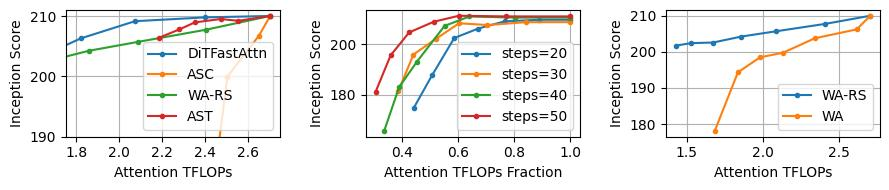

In [14]:
fig.savefig("plot/ablation.jpg", bbox_inches='tight')
fig.savefig("plot/ablation.pdf", bbox_inches='tight')
from PIL import Image
im=Image.open("plot/ablation.jpg")
im